In [1]:
#Import Dependencies and variables
import os
import plaid
import requests
import datetime
import json
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SBX_SECRET_KEY = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

In [4]:
print(len(PLAID_CLIENT_ID))
print(len(PLAID_PUBLIC_KEY))
print(len(PLAID_SBX_SECRET_KEY))

24
30
30


In [5]:
# Create client object
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SBX_SECRET_KEY, public_key=PLAID_PUBLIC_KEY, environment= 'sandbox')

In [6]:
#select an institution for processing
INSTITUTION_ID = "ins_109508"

# Create public token to be exchanged for institution access token
create_tkn_response = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

# Exchange public token for access token
exchange_response = client.Item.public_token.exchange(create_tkn_response['public_token'])

# Store access token as variable
access_token = exchange_response['access_token']


In [7]:
# Test the access token by requesting and printing the available test accounts
account_response = client.Accounts.get(access_token)
account_response

{'accounts': [{'account_id': 'KDebLjyNlJfx19axjzjetxxR59mox1fVpnD1p',
   'balances': {'available': 100,
    'current': 110,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '0000',
   'name': 'Plaid Checking',
   'official_name': 'Plaid Gold Standard 0% Interest Checking',
   'subtype': 'checking',
   'type': 'depository'},
  {'account_id': 'rnLr6lKWmvCK7WQKEjE4fgg4Jv6xgjIlJok1R',
   'balances': {'available': 200,
    'current': 210,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '1111',
   'name': 'Plaid Saving',
   'official_name': 'Plaid Silver Standard 0.1% Interest Saving',
   'subtype': 'savings',
   'type': 'depository'},
  {'account_id': 'zX4N6dAwDvcEXG8EbVbvCnnvl1kqnJtoNqXQ5',
   'balances': {'available': None,
    'current': 1000,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '2222',
   'name': 'Plaid CD',
   'officia

In [8]:
account_response.keys()

dict_keys(['accounts', 'item', 'request_id'])

# Account Transactions with Plaid
1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

In [9]:
# Get transactions for institution for specific date range
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now())

# Use the access token to fetch the transactions for the last 90 days
transaction_response = client.Transactions.get(access_token,start_date,end_date)

# Print JSON output
print(json.dumps(transaction_response['transactions'][:2],indent=4, sort_keys=True))
#transaction_response.keys()

[
    {
        "account_id": "KDebLjyNlJfx19axjzjetxxR59mox1fVpnD1p",
        "account_owner": null,
        "amount": 6.33,
        "category": [
            "Travel",
            "Car Service",
            "Ride Share"
        ],
        "category_id": "22006001",
        "date": "2019-10-01",
        "iso_currency_code": "USD",
        "location": {
            "address": null,
            "city": null,
            "country": null,
            "lat": null,
            "lon": null,
            "postal_code": null,
            "region": null,
            "store_number": null
        },
        "name": "Uber 072515 SF**POOL**",
        "payment_meta": {
            "by_order_of": null,
            "payee": null,
            "payer": null,
            "payment_method": null,
            "payment_processor": null,
            "ppd_id": null,
            "reason": null,
            "reference_number": null
        },
        "pending": false,
        "pending_transaction_id": null,
     

In [10]:
# Print the categories for each transaction
category_info = client.Transactions.get(access_token,start_date,end_date)
#if transactions in category_info ["transactions"]:
    #if transactions ['name'] == 
#category_info['transactions'][0].key()
print({category
       for transaction in category_info['transactions'] if transaction['category'] is not None
       for category in transaction['category']})


{'Credit', 'Payment', 'Sporting Goods', 'Deposit', 'Travel', 'Transfer', 'Recreation', 'Airlines and Aviation Services', 'Ride Share', 'Debit', 'Gyms and Fitness Centers', 'Credit Card', 'Coffee Shop', 'Shops', 'Food and Drink', 'Car Service', 'Restaurants'}


In [11]:
catagory_df = pd.DataFrame(transaction_response['transactions'], columns=['date','name','amount','category'])
catagory_df['category'] = catagory_df['category'].str[0]
catagory_df

,date,name,amount,category
0,2019-10-01,Uber 072515 SF**POOL**,6.33,Travel
1,2019-09-28,Tectra Inc,500.00,Food and Drink
2,2019-09-27,AUTOMATIC PAYMENT - THANK,2078.50,Payment
3,2019-09-27,KFC,500.00,Food and Drink
4,2019-09-27,Madison Bicycle Shop,500.00,Shops
5,2019-09-18,CREDIT CARD 3333 PAYMENT *//,25.00,Payment
6,2019-09-18,Uber 063015 SF**POOL**,5.40,Travel
7,2019-09-17,ACH Electronic CreditGUSTO PAY 123456,5850.00,Transfer
8,2019-09-17,CD DEPOSIT .INITIAL.,1000.00,Transfer
9,2019-09-16,Touchstone Climbing,78.50,Recreation


In [12]:
#Convert Data Type and Set Amount to float
catagory_df['date'] = pd.to_datetime(catagory_df['date'])
catagory_df.set_index('date', inplace = True) 
catagory_df.astype({'amount': 'float'}).dtypes


name         object
amount      float64
category     object
dtype: object

In [13]:
catagory_df.head()

,name,amount,category
date,,,
2019-10-01,Uber 072515 SF**POOL**,6.33,Travel
2019-09-28,Tectra Inc,500.00,Food and Drink
2019-09-27,AUTOMATIC PAYMENT - THANK,2078.50,Payment
2019-09-27,KFC,500.00,Food and Drink
2019-09-27,Madison Bicycle Shop,500.00,Shops


# Income Analysis with Plaid

1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [15]:
# Determine the previous year's gross income and print the results
response = client.Income.get(access_token)
income = response['income']
income

{'income_streams': [{'confidence': 0.99,
   'days': 690,
   'monthly_income': 500,
   'name': 'UNITED AIRLINES'}],
 'last_year_income': 6000,
 'last_year_income_before_tax': 7285,
 'max_number_of_overlapping_income_streams': 1,
 'number_of_income_streams': 1,
 'projected_yearly_income': 6085,
 'projected_yearly_income_before_tax': 7389}

# Budget Analysis

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calulate the expenses per month
4. Plot the total expenses per month

In [16]:
# Calculate the total spending per category and print the results
##

total_spending_df = catagory_df.groupby('category')['amount'].sum().to_frame()
total_spending_df

,amount
category,
Food and Drink,1105.73
Payment,2103.50
Recreation,78.50
Shops,500.00
Transfer,6845.78
Travel,11.73


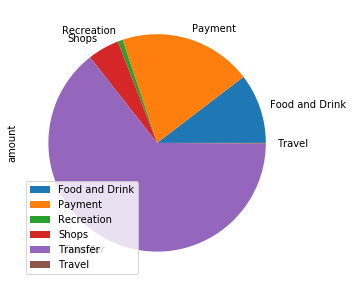

In [17]:
total_spending_df.plot.pie(y='amount', figsize=(5, 5))

In [26]:
catagory_df.tail()

,name,amount,category
date,,,
2019-09-15,McDonald's,12.00,Food and Drink
2019-09-15,Starbucks,4.33,Food and Drink
2019-09-14,SparkFun,89.40,Food and Drink
2019-09-13,INTRST PYMNT,-4.22,Transfer
2019-09-03,United Airlines,500.00,Travel


In [18]:
#catagory_df.groupby('date')["amount"].resample("M").sum()
month = catagory_df.groupby(pd.Grouper(freq='M')).sum()

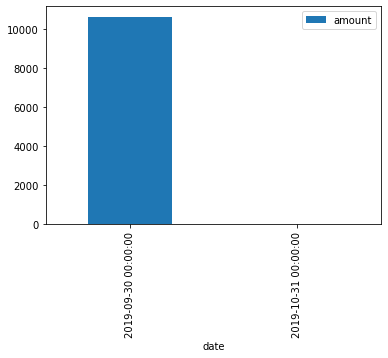

In [19]:
month.plot(kind='bar')